# COMP13212 Data Science - Lab 5 Solutions - Eesa Ahmad
------

## 1. Get the Data

In [1]:
import pandas as pd

df = pd.read_csv("spam.csv", keep_default_na=False, encoding="latin-1")
df.head(20)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",,,
1,ham,Ok lar... Joking wif u oni...,,,
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,,,
3,ham,U dun say so early hor... U c already then say...,,,
4,ham,"Nah I don't think he goes to usf, he lives aro...",,,
5,spam,FreeMsg Hey there darling it's been 3 week's n...,,,
6,ham,Even my brother is not like to speak with me. ...,,,
7,ham,As per your request 'Melle Melle (Oru Minnamin...,,,
8,spam,WINNER!! As a valued network customer you have...,,,
9,spam,Had your mobile 11 months or more? U R entitle...,,,


## 2. Clean the Data

In [2]:
# Fix Data
df["v2"] += df[df.columns[2]] + df[df.columns[3]] + df[df.columns[4]]
df = df.drop(columns=df.columns[[2,3,4]])
clean = df.rename(columns={"v1": "Category", "v2": "Message"})

# Clean Data
clean["Message"] = clean["Message"].str.lower()
clean["Message"] = clean["Message"].str.replace("[^a-zA-Z|^\ ]", "", regex=True)
clean.head(5)

,Category,Message
0,ham,go until jurong point crazy available only in ...
1,ham,ok lar joking wif u oni
2,spam,free entry in a wkly comp to win fa cup final...
3,ham,u dun say so early hor u c already then say
4,ham,nah i dont think he goes to usf he lives aroun...


## 3. Split the Data

In [3]:
train_data = clean.sample(frac=0.75)
test_data = clean[~clean.index.isin(train_data.index)]
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [168]:
print(f"Size of Train Data: {len(train_data)}")
print(f"Size of Test Data: {len(test_data)}")

Size of Train Data: 4179
Size of Test Data: 1393


## 4. Create a Word Frequency DataFrame

In [4]:
# Word Frequency Separately
spam = train_data[train_data["Category"] == "spam"]
ham = train_data[train_data["Category"] == "ham"]
num_spam = pd.DataFrame(spam["Message"].str.split(expand=True).stack().value_counts())
num_ham = pd.DataFrame(ham["Message"].str.split(expand=True).stack().value_counts())

# Create Word Frequency DataFrame
word_freq = pd.concat([num_spam, num_ham], axis=1).reset_index(level=0).fillna(0)
word_freq.columns = ["Word", "#Spam", "#Ham"]
word_freq = word_freq.astype({"#Spam": "int", "#Ham": "int"})
word_freq

,Word,#Spam,#Ham
0,to,537,1161
1,a,296,806
2,call,277,164
3,you,219,1367
4,your,197,318
...,...,...,...
7297,springs,0,1
7298,mirror,0,1
7299,tas,0,1
7300,rejected,0,1


## 5. Visualise the Data Using Word Cloud

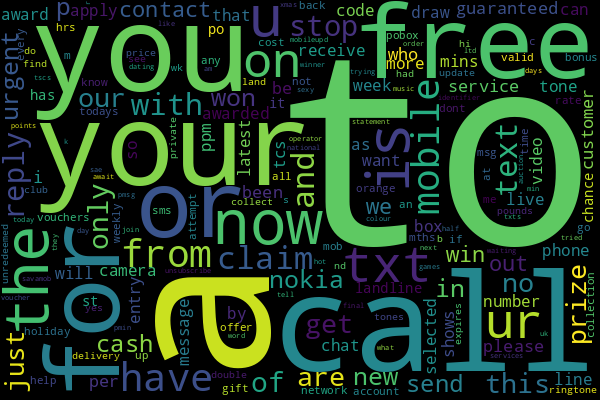

In [5]:
from wordcloud import WordCloud
wordcloud_df = word_freq.drop(columns="#Ham")
word_dict = {}
for w, f in wordcloud_df.values:
    word_dict[w] = f
WordCloud(width=600, height=400).generate_from_frequencies(frequencies=word_dict).to_image()

## 6. Calculate $P\left(E\middle| S\right)$ and $P\left(E|\lnot S\right)$

In [6]:
k = 0.5
total_spam = len(spam)
total_ham = len(ham)
word_prob = word_freq
word_prob.columns = ["Word", "P(E|S)", "P(E|¬S)"]
word_prob = word_prob.apply(lambda x: (x+k)/(total_spam+2*k) if x.name == "P(E|S)" else x)
word_prob = word_prob.apply(lambda x: (x+k)/(total_ham+2*k) if x.name == "P(E|¬S)" else x)
word_prob

,Word,P(E|S),P(E|¬S)
0,to,0.939685,0.321834
1,a,0.518357,0.223469
2,call,0.485140,0.045580
3,you,0.383741,0.378914
4,your,0.345280,0.088252
...,...,...,...
7297,springs,0.000874,0.000416
7298,mirror,0.000874,0.000416
7299,tas,0.000874,0.000416
7300,rejected,0.000874,0.000416


## 7. Checking the 'Spamliness' of a Single Word

In [96]:
word = "free"
spam_prob = float(word_prob[word_prob["Word"] == word]["P(E|S)"])
ham_prob = float(word_prob[word_prob["Word"] == word]["P(E|¬S)"])
prior_spam = 0.4
prior_ham = 0.6

spamliness = (spam_prob*prior_spam)/((spam_prob*prior_spam)+(ham_prob*prior_ham))
hamliness = (ham_prob*prior_ham)/((spam_prob*prior_spam)+(ham_prob*prior_ham))

# Print Probabilities
print(f"""Output
Word = ['{word}']
P(E|S) = [{spam_prob}]
P(E|¬S) = [{ham_prob}]
P(S|E) = [{spamliness}]
P(¬S|E) = [{hamliness}]""")

Output
Word = ['free']
P(E|S) = [0.28583916083916083]
P(E|¬S) = [0.010944860072042118]
P(S|E) = [0.9456842358314802]
P(¬S|E) = [0.05431576416851974]


## 8. Checking the 'Spamliness' of Several Words

In [140]:
# Randomly Generated Message
message = "I especially appreciate how helpful and kind you've been throughout this entire process, it means a lot to me."
message_clean = ""
for char in message:
    if char.isalpha() or char == " ":
       message_clean += char
message = message_clean.lower().split()

prob_spam = prior_spam
prob_ham = prior_ham
for word in message:
    if not (word_prob["Word"] == word).any():
        continue
    prob_spam *= float(word_prob[word_prob["Word"] == word]["P(E|S)"])
    prob_ham *= float(word_prob[word_prob["Word"] == word]["P(E|¬S)"])

evidence = prob_spam + prob_ham
prob_spam /= evidence
prob_ham /= evidence
print(f"Probability of Spam: {prob_spam}")
print(f"Probability of Not Spam: {prob_ham}")

# Check if Spam
if prob_spam > prob_ham:
    print("Message is Spam")
else:
    print("Message is NOT Spam")

Probability of Spam: 0.001821357228001934
Probability of Not Spam: 0.9981786427719981
Message is NOT Spam


## 9. Avoiding Floating Point Underflow

In [155]:
from math import log2

message = "I especially appreciate how helpful and kind you've been throughout this entire process, it means a lot to me."
message_clean = ""
for char in message:
    if char.isalpha() or char == " ":
       message_clean += char
message = message_clean.lower()

def spam_filter(message, info=False):
    message = message.lower().split()
    log_prob_spam = log2(prior_spam)
    log_prob_ham = log2(prior_ham)
    for word in message:
        if not (word_prob["Word"] == word).any():
            continue
        log_prob_spam += log2(float(word_prob[word_prob["Word"] == word]["P(E|S)"]))
        log_prob_ham += log2(float(word_prob[word_prob["Word"] == word]["P(E|¬S)"]))
    
    if info == True:
        print(f"Log of Prob Spam (numerator): {log_prob_spam}")
        print(f"Log of Prob Ham (numerator): {log_prob_ham}")

    if log_prob_spam > log_prob_ham: return "spam"
    else: return "ham"

if spam_filter(message, True) == "spam":
    print("Message is Spam")
else:
    print("Message is NOT Spam")

Log of Prob Spam (numerator): -110.18960339962737
Log of Prob Ham (numerator): -101.09146308384344
Message is NOT Spam


## 10. Testing the Model

In [165]:
match_spam, match_ham, thought_ham_is_spam, thought_spam_is_ham = 0, 0, 0, 0
test_data["Message"][0]

for i in test_data.index:
    if spam_filter(test_data["Message"][i]) == "spam":
        if test_data["Category"][i] == "spam":
            match_spam += 1
        else:
            thought_ham_is_spam += 1
    else:
        if test_data["Category"][i] == "ham":
            match_ham += 1
        else:
            thought_spam_is_ham += 1

print(f"""match_spam {match_spam}
match_ham {match_ham}
thought_ham_is_spam {thought_ham_is_spam}
thought_spam_is_ham {thought_spam_is_ham}
Accuracy: {(match_spam+match_ham)/len(test_data)}""")

match_spam 171
match_ham 1049
thought_ham_is_spam 168
thought_spam_is_ham 5
Accuracy: 0.8758076094759512


## 11. Improvements

- Use a larger set of training data for the spam filter, that is very varied.
- Remove words that are very common and don't influence the "spamliness" of a message, such as "a" or "to".
- Use more optimised values for the prior spam and ham probabilities
- Use common features of spam messages such as symbols, urls, and phone numbers.